# MNIST Handwritten Digits

In [105]:
# Imports
from sklearn.datasets import fetch_mldata
import numpy as np
import matplotlib.pyplot as plt
import time as tm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [106]:
# Fetch dataset
mnist = fetch_mldata('MNIST original')

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=10000)

## Image deskewing

Deskewing is the process of straightening an image that has been scanned or written crookedly

In [107]:
from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

In [108]:
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    img = interpolation.affine_transform(image,affine,offset=offset)
    return (img - img.min()) / (img.max() - img.min())

In [109]:
def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

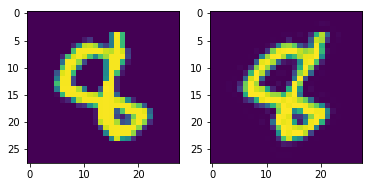

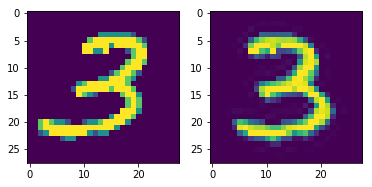

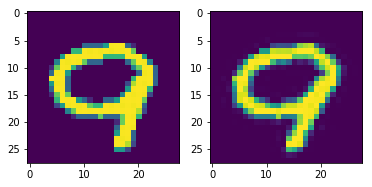

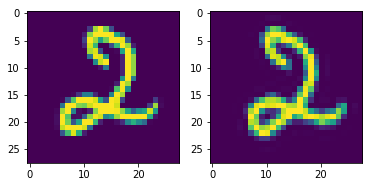

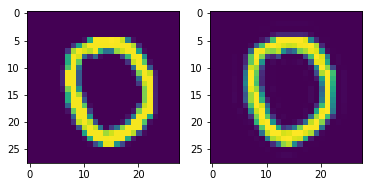

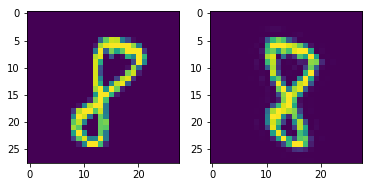

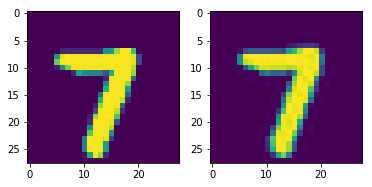

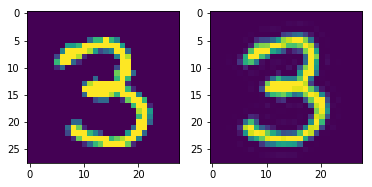

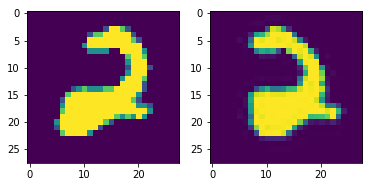

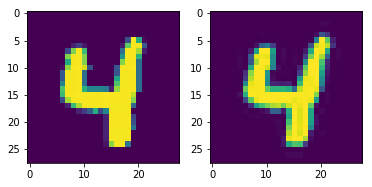

In [110]:
examples = [101, 10000, 15003, 22000, 26002, 35000, 37003, 43004, 53000, 57014]

for example in examples:   
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[example].reshape(28,28))

    newim = deskew(X_train[example].reshape(28,28))
    plt.subplot(1, 2, 2)
    plt.imshow(newim)
    plt.show()

In [111]:
X_train_deskewed = deskewAll(X_train)
X_test_deskewed = deskewAll(X_test)

## Linear Discriminant Analysis

In [98]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### Experiments

In [13]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_train_deskewed, y_train, test_size=0.33)

start = tm.time()

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_exp, y_train_exp)

score = accuracy_score(y_test_exp, lda.predict(X_test_exp))
minutes = (tm.time() - start) / 60
print("Linear Discriminant Analysis. Score: %f Time elapsed: %d minutes" % (score, minutes))

/usr/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Linear Discriminant Analysis. Score: 0.910808 Time elapsed: 2 minutes


## K-Nearest-Neighbours

In [9]:
from sklearn.neighbors import KNeighborsClassifier

### Experiments

In [36]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_train_deskewed, y_train, test_size=0.33)

start = tm.time()
k = 3

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_exp, y_train_exp)

score = accuracy_score(y_test_exp, knn.predict(X_test_exp))
minutes = (tm.time() - start) / 60
print("%d Nearest Neighbours. Score: %f Time elapsed: %d minutes" % (k, score, minutes))

9 Nearest Neighbours. Score: 0.981919 Time elapsed: 21 minutes


### Parameter Tuning

K-Fold Cross Validation for 3 neighbours took 41 minutes
K-Fold Cross Validation for 5 neighbours took 33 minutes
K-Fold Cross Validation for 7 neighbours took 34 minutes
K-Fold Cross Validation for 9 neighbours took 34 minutes
K-Fold Cross Validation for 11 neighbours took 34 minutes
K-Fold Cross Validation for 13 neighbours took 34 minutes
K-Fold Cross Validation for 15 neighbours took 34 minutes
K-Fold Cross Validation for 17 neighbours took 33 minutes
K-Fold Cross Validation for 19 neighbours took 34 minutes
K-Fold Cross Validation for 21 neighbours took 34 minutes
K-Fold Cross Validation for 23 neighbours took 34 minutes
K-Fold Cross Validation for 25 neighbours took 34 minutes
K-Fold Cross Validation for 27 neighbours took 35 minutes
K-Fold Cross Validation for 29 neighbours took 34 minutes
Optimal k for k-nn is: 3
Cross validation took 29323 seconds


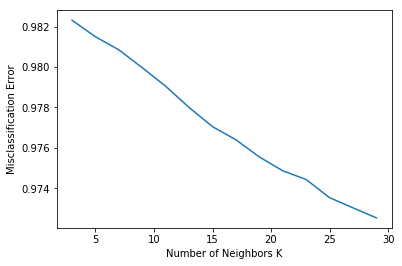

In [9]:
neighbours = [x for x in range(3,30,2)]
cv_scores = []
X_knn_cv, y_knn_cv = 

start = tm.time()
for k in neighbours:
    start_iter = tm.time()
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_deskewed, y_train, scoring='accuracy', n_jobs=3, shuffle=True)
    cv_scores.append(scores.mean())
    iteration = (tm.time() - start_iter) / 60
    print("K-Fold Cross Validation for %d neighbours." % (k))
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))
    print("Elapsed time: %d minutes" % (iteration))
    print()

optimal_k = neighbours[cv_scores.index(max(cv_scores))] # optimal k according to cv is 3
print('Optimal k for k-nn is: %d\nCross validation took %d seconds' % (optimal_k, tm.time() - start))
    
plt.plot(neighbours, mse)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.show()

## Support Vector Machine

In [112]:
from sklearn.svm import SVC

### Experiments

In [ ]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_train_deskewed, y_train, test_size=0.33)

start = tm.time()

C = 10
kernel = 'rbf'
gamma = 0.01

svc = SVC(C=C, kernel=kernel, gamma=gamma)
svc.fit(X_train_exp, y_train_exp)

score = accuracy_score(y_test_exp, svc.predict(X_test_exp))
minutes = (tm.time() - start) / 60
print("Support Vector Machine. Score: %f Time elapsed: %d minutes" % (score, minutes))

### Parameter Tuning

In [11]:
C_range = [1,10,100]
gamma_range = [0.001, 0.01, 0.1]

parameters = [{'kernel': ['rbf'],
               'gamma': gamma_range,
                'C': C_range},
              {'kernel': ['linear'], 'C': C_range}]

svc = SVC()
start = tm.time()
clf = GridSearchCV(svc, parameters, scoring="accuracy", n_jobs=3)
clf.fit(X_train_deskewed, y_train)
elapsed = (tm.time() - start) / 60

print("Best score: %0.5f" % (clf.best_score_))
print("Best parameters: %s" % (str(clf.best_params_)))
print("Time elapsed: %d minutes" % (elapsed))
print()

print("Grid scores on training set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("Accuracy %0.3f (+/-%0.03f) for parameters: %r"
          % (mean, std * 2, params))

# Results:
# Best score: 0.98578
# Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

NameError: name 'SVC' is not defined

## Random Forest

In [104]:
from sklearn.ensemble import RandomForestClassifier

### Experiments

In [28]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_train_deskewed, y_train, test_size=0.33)

start = tm.time()

n_estimators = 500
max_features = 'log2'
min_samples_leaf = 50
criterion = 'entropy'
max_depth = 500
oob_score = True

rfc = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, oob_score=oob_score, max_depth=max_depth, random_state=0)
rfc.fit(X_train_exp, y_train_exp)

score = accuracy_score(y_test_exp, rfc.predict(X_test_exp))
minutes = (tm.time() - start) / 60
print("Random Forest Classifier. Score: %f Time elapsed: %d minutes" % (score, minutes))

Random Forest Classifier. Score: 0.975808 Time elapsed: 4 minutes


### Parameter Tuning

In [12]:
from scipy.stats import randint

features = ["log2", "sqrt"]
samples_leaf = randint(1, 50)
criterion = ["gini", "entropy"]
oob = [True, False]
depth = randint(10, 500)

param_grid = {'criterion': criterion,
              'max_features': features,
              'min_samples_leaf': samples_leaf,
              'max_depth': depth,
              'oob_score': oob}

clf = RandomForestClassifier(n_estimators=500)
start = tm.time()

n_iter = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=n_iter, scoring="accuracy", n_jobs=3)
random_search.fit(X_train_deskewed, y_train)

elapsed = (tm.time() - start) / 60

print("Best score: %0.5f" % (random_search.best_score_))
print("Best parameters: %s" % (str(random_search.best_params_)))
print("Time elapsed: %d minutes" % (elapsed))
print()

print("Scores for tested parameters:")
means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, random_search.cv_results_['params']):
    print("%Accuracy 0.3f (+/-%0.03f)\nParameters: %r"
          % (mean, std * 2, params))
    print()

# Results
#Best score: 0.97403
#Best parameters: {'criterion': 'entropy', 'max_depth': 331, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'oob_score': False}

Best score: 0.97290
Best parameters: {'criterion': 'gini', 'max_depth': 124, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'oob_score': True}
Time elapsed: 104 minutes
0.95770 accuracy for parameters: {'criterion': 'gini', 'max_depth': 58, 'max_features': 'log2', 'min_samples_leaf': 17, 'oob_score': True}
0.94822 accuracy for parameters: {'criterion': 'entropy', 'max_depth': 450, 'max_features': 'log2', 'min_samples_leaf': 49, 'oob_score': False}
0.96052 accuracy for parameters: {'criterion': 'gini', 'max_depth': 408, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'oob_score': True}
0.96777 accuracy for parameters: {'criterion': 'gini', 'max_depth': 158, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'oob_score': True}
0.95652 accuracy for parameters: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 31, 'oob_score': True}
0.95203 accuracy for parameters: {'criterion': 'entropy', 'max_depth': 88, 'max_features': 'sqrt', 'min_samples_leaf': 45, 'oo

## Model Selection

We have tuned the parameter of 4 possible models. Now we will perform k-fold cross validation on these 4 models and select the best one

In [12]:
lda = LinearDiscriminantAnalysis()
knn = KNeighborsClassifier(n_neighbors=3)
svc = SVC(C=10, kernel='rbf', gamma=0.01)
rfc = RandomForestClassifier(n_estimators=500, criterion='entropy', max_depth=331, max_features='sqrt', min_samples_leaf=1, oob_score=False)

#clfs = [lda]
clfs = [lda, knn, svc, rfc]
clfs_names = ["Linear Discriminant Analysis", "K-Nearest Neighbors", "Support Vector Machines", "Random Forest"]

In [ ]:
cv_scores = []

start = tm.time()
for clf, clf_name in zip(clfs, clfs_names):
    scores = cross_val_score(clf, X_train_deskewed, y_train, scoring='accuracy', n_jobs=3)
    cv_scores.append(scores.mean())
    print("%s:" % clf_name)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))
    print()

best_clf = clfs[cv_scores.index(max(cv_scores))]
print("Best classifier:", best_clf)

/usr/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


## Sources

* lecture slides
* http://scikit-learn.org
* https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
* http://pyml.sourceforge.net/doc/howto.pdf
* https://fsix.github.io/mnist/Deskewing.html
* https://stackoverflow.com/
* https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/